In [136]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV, cross_validate, GridSearchCV
import copy
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from collections import defaultdict
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, LinearSVC
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing

##### Appliances Energy Dataset 

In [3]:
# Appliances Energy Dataset
df = pd.read_csv('energydata_complete.csv')

df = df.drop(columns = ['date'])

x = df[['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']]
y = df['Appliances']
xtrain_energy, xtest_energy, ytrain_energy, ytest_energy = train_test_split(x, y, test_size=0.3, random_state=0) # xtrain - 13814 obs, xtest - 5921 obs

# Categorizing the target variable
xtrain_energy['energy_high'] = np.where(xtrain_energy.Appliances > xtrain_energy.Appliances.median(),1,0)
xtest_energy['energy_high'] = np.where(xtest_energy.Appliances > xtrain_energy.Appliances.median(),1,0)

xtrain2 = xtrain_energy.iloc[:,1:-1]
xtest2 = xtest_energy.iloc[:,1:-1]

ytrain_app_energy = xtrain_energy.iloc[:,-1]
ytest_app_energy = xtest_energy.iloc[:,-1] # 0's and 1's

# Data Scaling - Standardization - z = (X-mu)/sigma
xtrain2 = (xtrain2-xtrain2.mean())/(xtrain2.std())
xtest2 = (xtest2-xtest2.mean())/(xtest2.std())

# Ten best suited features
# Removing all the features having correlations less than 0.06
# Removing T_out to avoid multicollinearity with T6
xtrain_app_energy = xtrain2.drop(columns = ['T1', 'T4', 'T5', 'T7', 'T8', 'T9', 'RH_3', 'RH_4', 'RH_5', 'RH_7', 'RH_9', 'T_out', 'Visibility', 'Tdewpoint', 'Press_mm_hg', 'rv1', 'rv2'])
xtest_app_energy = xtest2.drop(columns = ['T1', 'T4', 'T5', 'T7', 'T8', 'T9', 'RH_3', 'RH_4', 'RH_5', 'RH_7', 'RH_9', 'T_out', 'Visibility', 'Tdewpoint', 'Press_mm_hg', 'rv1', 'rv2'])
print(xtrain_app_energy.columns)

Index(['lights', 'RH_1', 'T2', 'RH_2', 'T3', 'T6', 'RH_6', 'RH_8', 'RH_out',
       'Windspeed'],
      dtype='object')


##### German Credit Dataset

In [4]:
# German Credit Dataset
data = pd.read_csv('german_credit.csv',sep = ',')
print("Missing Values = ", data.isnull().values.sum()) #There are no missing values in any of the observations
data = data.rename(columns = {"default":"creditability"})
data1 = data.copy()
#print(data1.head(2))
# 0 = bad credit, 1 = good credit

data1.creditability.replace([0,1], [1,0], inplace=True)
print("Number of Credits ",data1.creditability.value_counts())
# Number of good credits = 700, Number of bad credits = 300

cont_vars = data1.select_dtypes(include=['int64']).drop(['creditability'],axis=1)
cont_vars = (cont_vars-cont_vars.min())/(cont_vars.max()-cont_vars.min())

data2 = data1.copy()
data3 = cont_vars.copy()

obj_data = data2.select_dtypes(include=['object']).copy()
obj_data = pd.get_dummies(obj_data, prefix=['account', 'credit','purpose','savings','present_since','marital_status','debtors','property','other_plans','housing','job','telephone','foreign'])
#print("obj_data", obj_data.head())

data3 = pd.concat([data1['creditability'],data3],axis=1)
data3.reset_index(drop=True, inplace=True)
obj_data.reset_index(drop=True, inplace=True)
df2 = pd.concat([data3,obj_data], axis=1)
#print("df2", df2.head(2))

# Splitting into train and test data
train,test = train_test_split(df2,test_size=0.30,random_state=0) # train=700, test=300
xtrain = train.iloc[:,1:]
xtest = test.iloc[:,1:]

ytrain = train.iloc[:,0]
ytest = test.iloc[:,0]

# Getting rid of the Class-Imbalance problem using SMOTE
sm = SMOTE(ratio='auto')
xtrain1, ytrain1 = sm.fit_sample(xtrain, ytrain)

print(np.shape(xtrain1))

Missing Values =  0
Number of Credits  1    700
0    300
Name: creditability, dtype: int64
(972, 61)


### Algorithms 

##### Cross-Validation 

In [5]:
def cross_val(clf, xtrain, ytrain, ytest, ypred1, ypred):
    score1 = cross_val_score(clf, xtrain, ytrain, cv=10, scoring='accuracy')
    score2 = cross_val_score(clf, xtrain, ytrain, cv=10, scoring='precision')
    score3 = cross_val_score(clf, xtrain, ytrain, cv=10, scoring='recall')
    score4 = cross_val_score(clf, xtrain, ytrain, cv=10, scoring='roc_auc')
    print('Train Error: ', 1-accuracy_score(ytrain, ypred1))
    print('Test Error: ', 1-accuracy_score(ytest, ypred))
    print("CV Accuracy: %0.2f (+/- %0.2f)" % (score1.mean(), score1.std()))
    print("CV Precision: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std()))
    print("CV Recall: %0.2f (+/- %0.2f)" % (score3.mean(), score3.std()))
    print("CV roc_auc: %0.2f (+/- %0.2f)" % (score4.mean(), score4.std()))
    cm = confusion_matrix(ytest,ypred)
    print(cm)
    return

##### ROC Curves 

In [6]:
def auc_roc (ytest, ypred):
    fpr,tpr,roc_auc = dict(),dict(),dict()
    fpr, tpr, _ = roc_curve(ytest, ypred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw=2
    plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return

##### Learning Curves 

In [9]:
def learning_curves(estimator, title, xtrain, ytrain, ylim=None, cv=10, scoring='accuracy', obj_line=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, xtrain, ytrain, cv=10, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")
    if obj_line:
        plt.axhline(y=obj_line, color='blue')
    plt.legend(loc="best")
    return plt

##### ANN - Tensor Flow - Keras

##### Appliances Data

In [145]:
model = Sequential() # Initialize the keras model
model.add(Dense(12, input_dim=xtrain_app_energy.shape[1], activation='relu')) # Input Layer
model.add(Dense(8, activation='relu')) # Hidden Layer
model.add(Dense(1, activation='sigmoid')) # Output layer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-7, momentum=0.9)
model.compile(optimizer=sgd_optimizer,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(xtrain_app_energy, ytrain_app_energy, epochs=250, batch_size=100, verbose=1, validation_split=0.1)
# After 250 iterations, accuracy = 0.7815

Train on 12432 samples, validate on 1382 samples
Epoch 1/250
12432/12432 [==============================] - 0s 20us/step - loss: 0.6641 - accuracy: 0.6030 - val_loss: 0.6407 - val_accuracy: 0.6187
Epoch 2/250
12432/12432 [==============================] - 0s 11us/step - loss: 0.6323 - accuracy: 0.6408 - val_loss: 0.6166 - val_accuracy: 0.6498
Epoch 3/250
12432/12432 [==============================] - 0s 11us/step - loss: 0.6143 - accuracy: 0.6662 - val_loss: 0.5992 - val_accuracy: 0.6737
Epoch 4/250
12432/12432 [==============================] - 0s 11us/step - loss: 0.6010 - accuracy: 0.6790 - val_loss: 0.5853 - val_accuracy: 0.6889
Epoch 5/250
12432/12432 [==============================] - 0s 10us/step - loss: 0.5905 - accuracy: 0.6896 - val_loss: 0.5739 - val_accuracy: 0.7033
Epoch 6/250
12432/12432 [==============================] - 0s 11us/step - loss: 0.5819 - accuracy: 0.7000 - val_loss: 0.5649 - val_accuracy: 0.7149
Epoch 7/250
12432/12432 [==============================] - 0s 1

In [146]:
train_results = model.evaluate(xtrain_app_energy, ytrain_app_energy, verbose=1)
print('Train Loss: ',train_results[0])
print('Train Accuracy: ',train_results[1])
test_results = model.evaluate(xtest_app_energy, ytest_app_energy, verbose=1)
print('Test Loss: ',test_results[0])
print('Test Accuracy: ',test_results[1])

13814/13814 [==============================] - 0s 15us/step
Train Loss:  0.4557909441612142
Train Accuracy:  0.7867380976676941
5921/5921 [==============================] - 0s 16us/step
Test Loss:  0.47674169697042373
Test Accuracy:  0.7782469391822815


In [147]:
y_pred=model.predict(xtest_app_energy)
y_pred =(y_pred>0.5)
cm = confusion_matrix(ytest_app_energy, y_pred)
print('Confusion Matrix:\n',cm) 
# total of true positive and true negative is 4608 out of 5921 observations in the test dataset
# so our accuracy for test dataset is around 78%

Confusion Matrix:
 [[2602  581]
 [ 732 2006]]


##### German Credit

In [149]:
model = Sequential() # Initialize the keras model
model.add(Dense(12, input_dim=xtrain1.shape[1], activation='relu')) # Input Layer
model.add(Dense(8, activation='relu')) # Hidden Layer
model.add(Dense(1, activation='sigmoid')) # Output layer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-7, momentum=0.9)
model.compile(optimizer=sgd_optimizer,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(xtrain1, ytrain1, epochs=250, batch_size=100, verbose=1, validation_split=0.1)
# After 250 iterations, accuracy = 0.7653

Train on 874 samples, validate on 98 samples
Epoch 1/250
874/874 [==============================] - 0s 106us/step - loss: 0.6811 - accuracy: 0.5503 - val_loss: 0.8019 - val_accuracy: 0.0918
Epoch 2/250
874/874 [==============================] - 0s 18us/step - loss: 0.6805 - accuracy: 0.5526 - val_loss: 0.8002 - val_accuracy: 0.0918
Epoch 3/250
874/874 [==============================] - 0s 21us/step - loss: 0.6796 - accuracy: 0.5561 - val_loss: 0.7975 - val_accuracy: 0.1020
Epoch 4/250
874/874 [==============================] - 0s 19us/step - loss: 0.6787 - accuracy: 0.5584 - val_loss: 0.7940 - val_accuracy: 0.1224
Epoch 5/250
874/874 [==============================] - 0s 18us/step - loss: 0.6777 - accuracy: 0.5595 - val_loss: 0.7910 - val_accuracy: 0.1224
Epoch 6/250
874/874 [==============================] - 0s 17us/step - loss: 0.6767 - accuracy: 0.5618 - val_loss: 0.7888 - val_accuracy: 0.1224
Epoch 7/250
874/874 [==============================] - 0s 15us/step - loss: 0.6757 - accur

In [139]:
predictions = model.predict_classes(xtrain1)
for i in range(5):
    print('%s => %d (expected %d)' % (xtrain1[i].tolist(), predictions[i], ytrain1[i]))

[0.29411764705882354, 0.6431165401122483, 0.3333333333333333, 0.6666666666666666, 0.35714285714285715, 0.3333333333333333, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0] => 0 (expected 0)
[0.47058823529411764, 0.08633212281280951, 1.0, 1.0, 0.32142857142857145, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0] => 0 (expected 0)
[0.16176470588235295, 0.06756905469351822, 1.0, 1.0, 0.44642857142857145, 0.3333333333333333, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

In [150]:
train_results = model.evaluate(xtrain1, ytrain1, verbose=1)
print('Train Loss: ',train_results[0])
print('Train Accuracy: ',train_results[1])
test_results = model.evaluate(xtest, ytest, verbose=1)
print('Test Loss: ',test_results[0])
print('Test Accuracy: ',test_results[1])

972/972 [==============================] - 0s 18us/step
Train Loss:  0.46020435526537795
Train Accuracy:  0.7716049551963806
300/300 [==============================] - 0s 23us/step
Test Loss:  0.5577245346705119
Test Accuracy:  0.7133333086967468


In [151]:
y_pred=model.predict(xtest)
y_pred =(y_pred>0.5)
cm = confusion_matrix(ytest, y_pred)
print('Confusion Matrix:\n ',cm) 
# total of true positive and true negative is 214 out 300 observations in the test dataset
# so our accuracy for test dataset is around 71%

Confusion Matrix:
  [[ 59  27]
 [ 59 155]]


##### Performance Tuning using Randomized Search 

In [ ]:
# German Credit Dataset

In [120]:
def keras_mlp_germanc(optimizer,activation,learn_rate,momentum):
    model = Sequential()
    model.add(Dense(12, input_dim=xtrain1.shape[1], activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = optimizers.SGD(lr=learn_rate, decay=1e-7, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [121]:
model = KerasClassifier(build_fn=keras_mlp_germanc, verbose=0, epochs=10, batch_size=10)

In [122]:
batch_size = [32,64]
epochs = [10,100,250]
learn_rate = [0.001, 0.01, 0.1]
activation = ['relu', 'tanh', 'sigmoid']
optimizer = ['SGD', 'Adam']
momentum=[0.5,0.8,0.9]
param_grid = dict(batch_size=batch_size, epochs=epochs,optimizer=optimizer,learn_rate=learn_rate,activation=activation,momentum=momentum)
rand = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=5)
rand_res = rand.fit(xtrain1, ytrain1)

In [123]:
print("Best: %f using %s" % (rand_res.best_score_, rand_res.best_params_))

Best: 0.813786 using {'optimizer': 'Adam', 'momentum': 0.5, 'learn_rate': 0.1, 'epochs': 250, 'batch_size': 64, 'activation': 'sigmoid'}


##### ANN - Feed Forward Multi Layer Perceptron

In [140]:
def mlp(xtrain, ytrain, xtest, ytest):
    mlp = MLPClassifier(solver='lbfgs', alpha=5, hidden_layer_sizes=(75,75))
    mlp_model = mlp.fit(xtrain, ytrain)
    print(mlp_model.get_params)
    ypred1 = mlp_model.predict(xtrain)
    ypred = mlp_model.predict(xtest)
    cross_val(mlp_model, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

##### Parameter tuning 

In [135]:
mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50), (75,75), (100,100)],
    'activation': ['logistic','tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}
model = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
model.fit(xtrain1, ytrain1)
print('Best parameters:\n', model.best_params_)
ytrue, ypred = ytest , model.predict(xtest)
print('Results on the test set:')
print(classification_report(ytrue, ypred))

Best parameters:
 {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Results on the test set:
              precision    recall  f1-score   support

           0       0.58      0.59      0.59        86
           1       0.83      0.83      0.83       214

    accuracy                           0.76       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.76      0.76      0.76       300



##### ROC and Learning curves 

<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(75, 75), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)>
Train Error:  0.12429419429564215
Test Error:  0.1567302820469515
CV Accuracy: 0.84 (+/- 0.01)
CV Precision: 0.84 (+/- 0.01)
CV Recall: 0.81 (+/- 0.02)
CV roc_auc: 0.92 (+/- 0.01)
[[2772  411]
 [ 517 2221]]


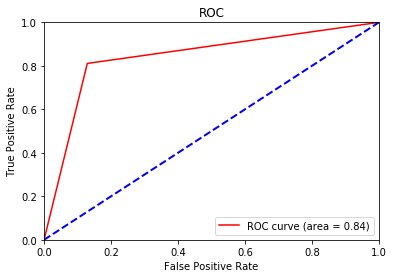

In [9]:
mlp(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

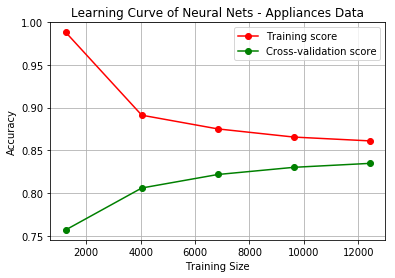

In [14]:
learning_curves(MLPClassifier(solver='lbfgs'),'Learning Curve of Neural Nets - Appliances Data', xtrain_app_energy,ytrain_app_energy)

<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)>
Train Error:  0.0
Test Error:  0.27
CV Accuracy: 0.85 (+/- 0.07)
CV Precision: 0.89 (+/- 0.11)
CV Recall: 0.78 (+/- 0.05)
CV roc_auc: 0.90 (+/- 0.06)
[[ 51  35]
 [ 46 168]]


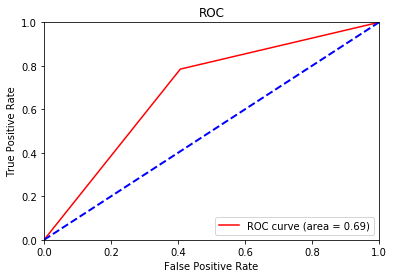

In [141]:
mlp(xtrain1, ytrain1, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

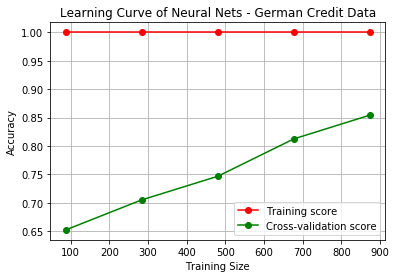

In [142]:
learning_curves(MLPClassifier(activation='relu', alpha=0.01,solver='adam',hidden_layer_sizes=(100,100)),'Learning Curve of Neural Nets - German Credit Data', xtrain1,ytrain1)

##### KNN 

In [152]:
def knn(xtrain, ytrain, xtest, ytest):  
    knn = KNeighborsClassifier(n_neighbors=3,metric="euclidean")
    knn_model = knn.fit(xtrain, ytrain)
    print(knn_model.get_params)
    ypred1 = knn_model.predict(xtrain)
    ypred = knn_model.predict(xtest)
    cross_val(knn_model, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

##### KNN Implementation

##### Parameter tuning using cross-validation 

[0.8691179833919598, 0.8559433171260062, 0.8694807207936833, 0.8567390044113985, 0.8607205779315128, 0.8457356821121511, 0.8537713983943102, 0.8416102288249409, 0.8467494928059824, 0.8421889952340635, 0.8430580876729763, 0.8352391865657932, 0.8376280786455478, 0.831040588589719, 0.833792061034688, 0.827276772766723, 0.8295203707657673, 0.825755873794544, 0.8277831282585412, 0.8230055012113129, 0.8230784362403355, 0.8178662895505171, 0.8188069031594672, 0.8152600589417842, 0.8168527408367734, 0.8150425629974386, 0.81692499479334, 0.8138848725365113, 0.8138849771770034, 0.8112790609443751]


Text(0, 0.5, 'Cross-Validated Accuracy')

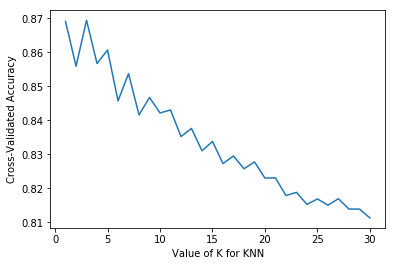

In [64]:
# Appliances Energy Dataset
k_range = range(1,31)
k_scores = []
#n = np.shape(xtrain1)[0]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xtrain_app_energy, ytrain_app_energy, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)
plt.plot(k_range, k_scores)
plt.xlabel('k')
plt.ylabel('Cross-Validated Accuracy')

[0.8269982993197278, 0.7425807823129251, 0.7776998299319728, 0.7323979591836735, 0.7509353741496598, 0.7221726190476192, 0.7396045918367347, 0.7211309523809524, 0.7356292517006804, 0.7160501700680273, 0.7313562925170067, 0.7190263605442176, 0.7231930272108843, 0.7118409863945578, 0.7107993197278911, 0.7076955782312926, 0.7180059523809523, 0.7045705782312924, 0.7056335034013606, 0.6994897959183672, 0.7005527210884354, 0.69640731292517, 0.698469387755102, 0.6943027210884354, 0.6994260204081633, 0.6984481292517006, 0.7035501700680272, 0.6932823129251702, 0.7036352040816327, 0.6943664965986394]


Text(0, 0.5, 'Cross-Validated Accuracy')

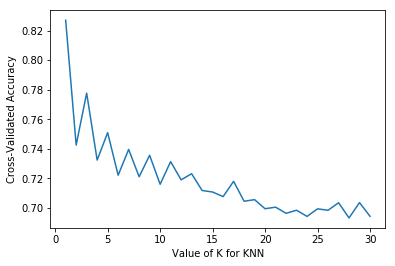

In [72]:
# German Credit Dataset
k_range = range(1,31)
k_scores = []
#n = np.shape(xtrain1)[0]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xtrain1, ytrain1, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)
plt.plot(k_range, k_scores)
plt.xlabel('k')
plt.ylabel('Cross-Validated Accuracy')

##### Parameter Tuning using Randomized Search CV 

In [63]:
# Appliances Energy Dataset
k = list(range(1, 31))
weights = ['uniform', 'distance']
param_dist = dict(n_neighbors=k, weights=weights)
knn = KNeighborsClassifier(n_neighbors=k)
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(xtrain_app_energy,ytrain_app_energy)
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.8715795569711886
{'weights': 'distance', 'n_neighbors': 10}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')


In [62]:
# German Credit Dataset
k = list(range(1, 31))
weights = ['uniform', 'distance']
param_dist = dict(n_neighbors=k, weights=weights)
knn = KNeighborsClassifier(n_neighbors=k)
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(xtrain1,ytrain1)
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.7685185185185185
{'weights': 'distance', 'n_neighbors': 10}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')


##### ROC and Learning Curves 

Train Error:  0.06536846677283914
Test Error:  0.12869447728424255
CV Accuracy: 0.87 (+/- 0.01)
CV Precision: 0.86 (+/- 0.01)
CV Recall: 0.85 (+/- 0.01)
CV roc_auc: 0.92 (+/- 0.00)
[[2857  326]
 [ 436 2302]]


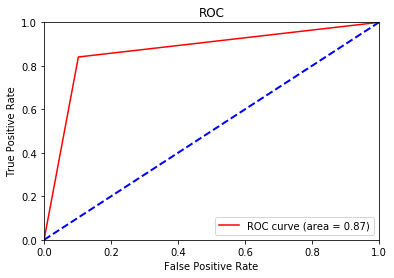

In [18]:
knn(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

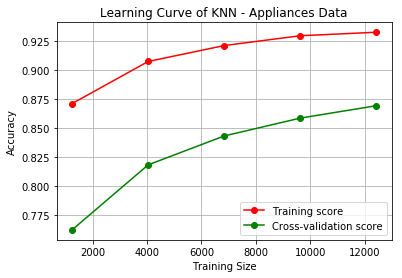

In [19]:
learning_curves(KNeighborsClassifier(n_neighbors=3),'Learning Curve of KNN - Appliances Data', xtrain_app_energy,ytrain_app_energy)

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')>
Train Error:  0.11831275720164613
Test Error:  0.37
CV Accuracy: 0.76 (+/- 0.05)
CV Precision: 0.89 (+/- 0.08)
CV Recall: 0.60 (+/- 0.08)
CV roc_auc: 0.85 (+/- 0.06)
[[ 64  22]
 [ 89 125]]


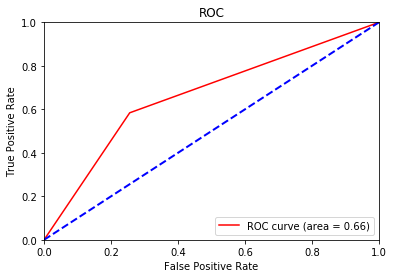

In [153]:
knn(xtrain1, ytrain1, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

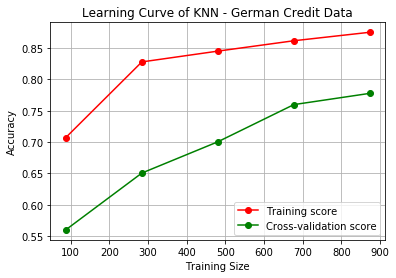

In [21]:
learning_curves(KNeighborsClassifier(n_neighbors=3),'Learning Curve of KNN - German Credit Data', xtrain1,ytrain1)